# Performing Machine Learning on Daily Basis Function Curves

This model performs machine learning (decision trees) on daily shapes.  This is the process:  

Model Preprocessing and Training:
1. Assume that y_hourly is a 24 hour curve.  For each day, the coefficients for a daily shape is calculated based on sinusoidal basis funcitons.  So y in the model is a set of coefficients for each day.  
2. Hourly input data X_hourly is transformed into daily data, with features for each day (e.g., temperature is transformed into max and min).  So X in the model is daily data.  
3. A decision tree is trained to predict the coefficients (y) for the daily shape based on the daily features (X).  

Model Prediction:
1. For new data at the daily level (X_new), the decision tree predicts the coefficients for the shape (y_pred).  These can then be converted back into an hourly curve using the basis function approach (y_pred_hourly).

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.tree import plot_tree
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

import helper_functions as hf

# Dummy Data

In [34]:
# Generate the dummy data
df = hf.generate_dummy_data()
df['year'] = df.index.year
df['month'] = df.index.month
df['day_of_week'] = df.index.dayofweek  # Monday=0, Sunday=6
df['hour_of_day'] = df.index.hour

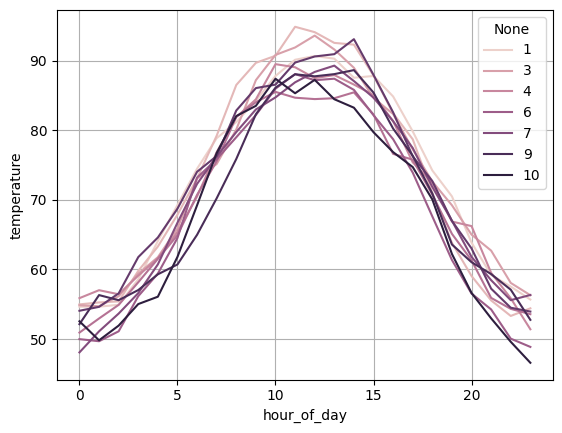

In [48]:
mask1 = df.year == 2005
mask2 = df.month == 9
plot_df = df.loc[mask1 & mask2].iloc[:240]
sns.lineplot(plot_df, x='hour_of_day', y='temperature', hue=plot_df.index.day)
plt.grid()

# The Model

In [39]:
def daily_basis_functions(hour, n_components=5):
    """Generate basis functions for a 24-hour cycle."""
    basis = np.zeros((len(hour), 1 + 2 * n_components))
    basis[:, 0] = 1  # Constant term
    for n in range(1, n_components + 1):
        basis[:, 2*n - 1] = np.cos(2 * np.pi * n * hour / 24)
        basis[:, 2*n] = np.sin(2 * np.pi * n * hour / 24)
    return basis

In [40]:
class BasisFunctionTreeRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, n_basis_components=5, **tree_params):
        self.n_basis_components = n_basis_components
        self.tree = DecisionTreeRegressor(**tree_params)
        self.linear_model = LinearRegression(fit_intercept=False)
    
    def transform_X_hourly_to_daily(self, X):
        X.index = pd.to_datetime(X.index)

        # Group by date and calculate daily max and min temperatures
        X_daily = X.groupby(X.index.date).agg({
            'temperature': ['max', 'min']
        })

        # Flatten the column names
        X_daily.columns = ['temp_max', 'temp_min']

        # Add year, month, and day of week
        X_daily = pd.concat(
            [
                X_daily, 
                X.groupby(X.index.date).mean().drop(columns=['temperature'])
            ], 
            axis=1
        )

        return X_daily

    def fit(self, X, y):
        # Reshape y into daily patterns
        y_daily = y.values.reshape(-1, 24)
        
        # Compute basis function coefficients for each day
        hour = np.arange(24)
        basis = daily_basis_functions(hour, self.n_basis_components)
        self.linear_model.fit(basis, y_daily.T)
        coeffs = self.linear_model.coef_

        # Transform X from hourly to daily
        X_daily = self.transform_X_hourly_to_daily(X)

        # Fit the tree to predict coefficients
        self.tree.fit(X_daily, coeffs)
        return self
    
    def predict(self, X):
        X_daily = self.transform_X_hourly_to_daily(X)
        # Predict coefficients
        pred_coeffs = self.tree.predict(X_daily)
        
        # Reconstruct hourly predictions using basis functions
        hour = np.arange(24)
        basis = daily_basis_functions(hour, self.n_basis_components)
        y_pred = np.dot(pred_coeffs, basis.T)
        
        return y_pred.flatten()

In [41]:
class BasisFunctionTreeRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, n_basis_components=5, **tree_params):
        self.n_basis_components = n_basis_components
        self.tree = DecisionTreeRegressor(**tree_params)
        self.linear_model = LinearRegression(fit_intercept=False)
        self.scaler = StandardScaler()
    
    def transform_X_hourly_to_daily(self, X):
        X.index = pd.to_datetime(X.index)

        # Group by date and calculate daily max and min temperatures
        X_daily = X.groupby(X.index.date).agg({
            'temperature': ['max', 'min']
        })

        # Flatten the column names
        X_daily.columns = ['temp_max', 'temp_min']

        # Add year, month, and day of week
        X_daily = pd.concat(
            [
                X_daily, 
                X.groupby(X.index.date).mean().drop(columns=['temperature'])
            ], 
            axis=1
        )

        return X_daily

    def fit(self, X, y):
        # Reshape y into daily patterns
        y_daily = y.values.reshape(-1, 24)
        
        # Compute basis function coefficients for each day
        hour = np.arange(24)
        basis = daily_basis_functions(hour, self.n_basis_components)
        self.linear_model.fit(basis, y_daily.T)
        coeffs = self.linear_model.coef_

        # Scale the coefficients
        self.scaler.fit(coeffs)
        scaled_coeffs = self.scaler.transform(coeffs)

        # Transform X from hourly to daily
        X_daily = self.transform_X_hourly_to_daily(X)

        # Fit the tree to predict scaled coefficients
        self.tree.fit(X_daily, scaled_coeffs)
        return self
    
    def predict(self, X):
        X_daily = self.transform_X_hourly_to_daily(X)
        # Predict scaled coefficients
        pred_scaled_coeffs = self.tree.predict(X_daily)
        
        # Unscale the coefficients
        pred_coeffs = self.scaler.inverse_transform(pred_scaled_coeffs)
        
        # Reconstruct hourly predictions using basis functions
        hour = np.arange(24)
        basis = daily_basis_functions(hour, self.n_basis_components)
        y_pred = np.dot(pred_coeffs, basis.T)
        
        return y_pred.flatten()

In [42]:
predictor_cols = ['temperature', 'year', 'month', 'day_of_week']
X = df[predictor_cols]
y = df['value']

Fit with 5 basis components and the default tree parameters.  

In [43]:
bftree = BasisFunctionTreeRegressor(n_basis_components=5)
bftree.fit(X, y)

BasisFunctionTreeRegressor()

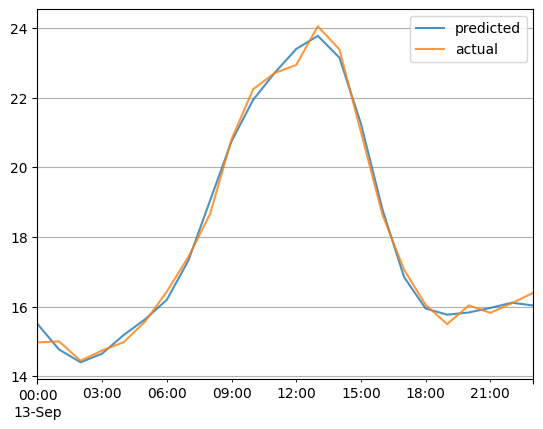

In [44]:
date = pd.to_datetime('2005-09-13')
mask = df.index.date == date.date()
X_new = df[mask][predictor_cols]
df_results = pd.DataFrame(index=X_new.index)
df_results['predicted'] = bftree.predict(X_new)
df_results['actual'] = df[mask]['value'].values
df_results.plot(alpha=.8)
plt.grid()

Fit with 10 basis components and the default tree parameters.  

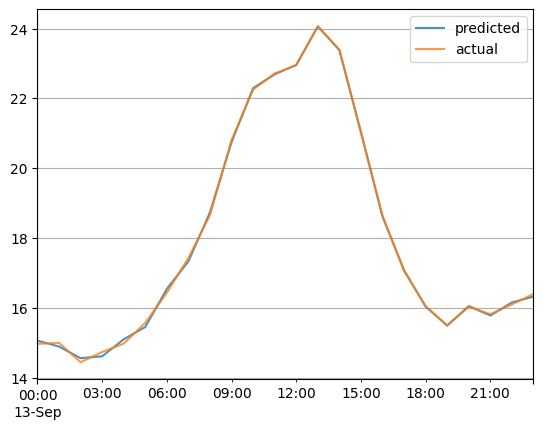

In [45]:
bftree = BasisFunctionTreeRegressor(n_basis_components=10)
bftree.fit(X, y)
df_results['predicted'] = bftree.predict(X_new)
df_results.plot(alpha=.8)
plt.grid()


Fit with 5 basis components and a max depth of 4 (16 bins).

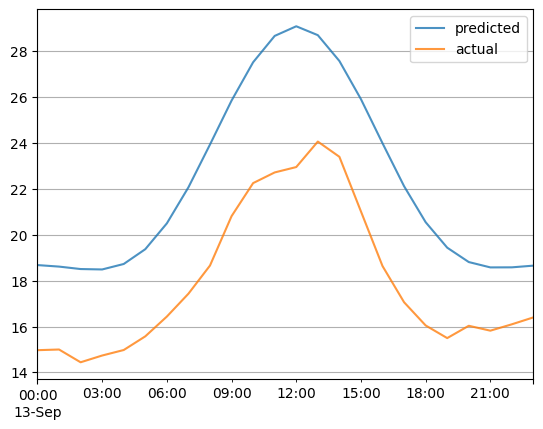

In [46]:
bftree = BasisFunctionTreeRegressor(n_basis_components=5, **{'max_depth':4})
bftree.fit(X, y)
df_results['predicted'] = bftree.predict(X_new)
df_results.plot(alpha=.8)
plt.grid()


There are 16 leaves in the tree, so each day is binned into one of 16 groups which are all assumed to have the same shape.  

Text(0.5, 1.0, 'Decision Tree Visualization (max_depth=3)')

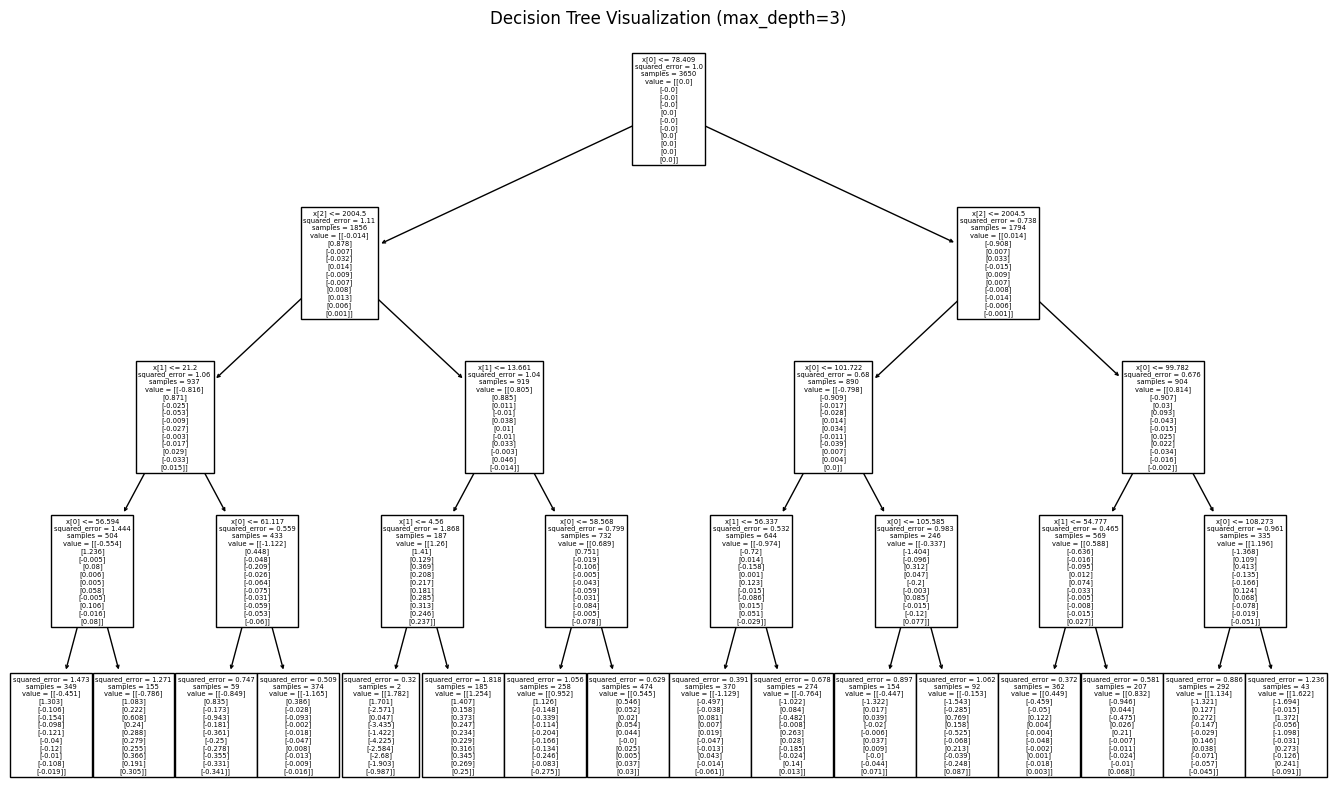

In [47]:
plt.figure(figsize=(17,10))
plot_tree(bftree.tree)
plt.title("Decision Tree Visualization (max_depth=3)")